# Antarctic SMB trends

Author: Ziqi Yin

Last edited: 2024 Jul 19

## Description

SMB and sea level pressure trends:
- Data: CESM2-LEcmip6 ensemble mean, CESM2-TPACE ensemble mean, CESM2-GOGA ensemble mean, CESM2-TOGA ensemble mean
- Period: 2005:2019 to 1979:1993

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.path as mpath
import matplotlib.colors as colors

import sys  
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
### --- Plot basemap of Antarctica with cartopy --- ###
def plot_antarctica_SO(ax, lat):
    coast_line = gpd.read_file('/glade/work/ziqiyin/shp_files/Coastline_Antarctica_v2.shp')
    grounding_line = gpd.read_file('/glade/work/ziqiyin/shp_files/GroundingLine_Antarctica_v2.shp')
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax.add_geometries(coast_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    #ax.add_geometries(grounding_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, lat], ccrs.PlateCarree())
    return

## Read data

In [3]:
## SMB variables
# MT19 (1801-2000)
path = '/glade/work/dschneid/zaria_snow/'

fn_SMB_MT = 'merra_medley_regrid.nc'
SMB_MT = xr.open_dataset(path+fn_SMB_MT).smb
lat_MT = np.array(SMB_MT.lat)
lon_MT = np.array(SMB_MT.lon)

# CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_RAIN_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.RAIN.185001-210012.nc'
RAIN_LE = xr.open_dataset(path+fn_RAIN_LE).RAIN #[mm/s]
lon = RAIN_LE.lon
lat = RAIN_LE.lat
fn_SNOW_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.SNOW.185001-210012.nc'
SNOW_LE = xr.open_dataset(path+fn_SNOW_LE).SNOW
fn_QSOIL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QSOIL.185001-210012.nc'
QSOIL_LE = xr.open_dataset(path+fn_QSOIL_LE).QSOIL
fn_QRUNOFF_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QRUNOFF.185001-210012.nc'
QRUNOFF_LE = xr.open_dataset(path+fn_QRUNOFF_LE).QRUNOFF
SMB_LE = RAIN_LE + SNOW_LE - QSOIL_LE - QRUNOFF_LE

#CESM2-TPACE (10 members, 1880-2019)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/tropical_pacific_pacemaker/'

fn_RAIN_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.RAIN.188001-201912.nc'
RAIN_TPACE = xr.open_dataset(path+fn_RAIN_TPACE).RAIN
fn_SNOW_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.SNOW.188001-201912.nc'
SNOW_TPACE = xr.open_dataset(path+fn_SNOW_TPACE).SNOW
fn_QSOIL_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.QSOIL.188001-201912.nc'
QSOIL_TPACE = xr.open_dataset(path+fn_QSOIL_TPACE).QSOIL
fn_QRUNOFF_TPACE = 'b.e21.BHISTcmip6.f09_g17.pacemaker_pacific.EM1-10.clm2.h0.QRUNOFF.188001-201912.nc'
QRUNOFF_TPACE = xr.open_dataset(path+fn_QRUNOFF_TPACE).QRUNOFF
SMB_TPACE = RAIN_TPACE + SNOW_TPACE - QSOIL_TPACE - QRUNOFF_TPACE

#CESM2-GOGA (10 members, 1880-2021)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/GOGA/'

fn_RAIN_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.RAIN.188001-202112.nc'
RAIN_GOGA = xr.open_dataset(path+fn_RAIN_GOGA).RAIN
fn_SNOW_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.SNOW.188001-202112.nc'
SNOW_GOGA = xr.open_dataset(path+fn_SNOW_GOGA).SNOW
fn_QSOIL_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.QSOIL.188001-202112.nc'
QSOIL_GOGA = xr.open_dataset(path+fn_QSOIL_GOGA).QSOIL
fn_QRUNOFF_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.QRUNOFF.188001-202112.nc'
QRUNOFF_GOGA = xr.open_dataset(path+fn_QRUNOFF_GOGA).QRUNOFF
SMB_GOGA = RAIN_GOGA + SNOW_GOGA - QSOIL_GOGA - QRUNOFF_GOGA

#CESM2-TOGA (10 members, 1880-2019)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/TOGA/'

fn_RAIN_TOGA = 'f.e21.FSSP370.f09_f09.historical.ssp370.ersstv5.toga.EM1-10.clm2.h0.RAIN.188001-201912.nc'
RAIN_TOGA = xr.open_dataset(path+fn_RAIN_TOGA).RAIN
fn_SNOW_TOGA = 'f.e21.FSSP370.f09_f09.historical.ssp370.ersstv5.toga.EM1-10.clm2.h0.SNOW.188001-201912.nc'
SNOW_TOGA = xr.open_dataset(path+fn_SNOW_TOGA).SNOW
fn_QSOIL_TOGA = 'f.e21.FSSP370.f09_f09.historical.ssp370.ersstv5.toga.EM1-10.clm2.h0.QSOIL.188001-201912.nc'
QSOIL_TOGA = xr.open_dataset(path+fn_QSOIL_TOGA).QSOIL
fn_QRUNOFF_TOGA = 'f.e21.FSSP370.f09_f09.historical.ssp370.ersstv5.toga.EM1-10.clm2.h0.QRUNOFF.188001-201912.nc'
QRUNOFF_TOGA = xr.open_dataset(path+fn_QRUNOFF_TOGA).QRUNOFF
SMB_TOGA = RAIN_TOGA + SNOW_TOGA - QSOIL_TOGA - QRUNOFF_TOGA

In [7]:
#CESM1-meltwater hosting (7 members, 1980-2013)
path = '/glade/derecho/scratch/dschneid/melt_concat/'

fn_RAIN_mw = 'cesm1.2.2.1.hose_ifw_B20TRC5CN.EM01-07.ydong.lnd.198001-201312.monthly.nc'
RAIN_mw = xr.open_dataset(path+fn_RAIN_mw).RAIN
fn_SNOW_mw = 'cesm1.2.2.1.hose_ifw_B20TRC5CN.EM01-07.ydong.lnd.198001-201312.monthly.nc'
SNOW_mw = xr.open_dataset(path+fn_SNOW_mw).SNOW
fn_QSOIL_mw = 'cesm1.2.2.1.hose_ifw_B20TRC5CN.EM01-07.ydong.lnd.198001-201312.monthly.nc'
QSOIL_mw = xr.open_dataset(path+fn_QSOIL_mw).QSOIL
fn_QRUNOFF_mw = 'cesm1.2.2.1.hose_ifw_B20TRC5CN.EM01-07.ydong.lnd.198001-201312.monthly.nc'
QRUNOFF_mw = xr.open_dataset(path+fn_QRUNOFF_mw).QRUNOFF
SMB_mw = RAIN_mw + SNOW_mw - QSOIL_mw - QRUNOFF_mw

In [4]:
# Zwally grounded ice sheet land mask (REMOVAL of ice shelves)
path = '/glade/work/dschneid/zaria_snow/'

fn_GROUNDEDMASK = 'AIS_Groundedmask_Zwally_CESMgrid.nc'
GROUNDEDMASK = xr.open_dataset(path+fn_GROUNDEDMASK).Groundedmask

# Select lat range
GROUNDEDMASK_sel = GROUNDEDMASK.sel(lat=slice(-90,-60))

# Rearrange the longitude for CESM2, from [0~360] to [-180~180]; actually for MT?
GROUNDEDMASK_sel_lon_new = GROUNDEDMASK_sel.lon.where(GROUNDEDMASK_sel.lon<=180, GROUNDEDMASK_sel.lon-360)
GROUNDEDMASK_sel['lon'] = GROUNDEDMASK_sel_lon_new
GROUNDEDMASK_sel_rearrange = GROUNDEDMASK_sel.sortby(GROUNDEDMASK_sel.lon)
# Note: in the calculation below, GROUNDEDMASK_sel_rearrange also needs to be add with ".values" since its lat values are not exactly the same to those in SMB_MT

In [5]:
## Correct time
dates = pd.date_range("1850-01-01", periods=251*12, freq='ME')
SMB_LE['time'] = dates

dates = pd.date_range("1880-01-01", periods=140*12, freq='ME')
SMB_TPACE['time'] = dates

dates = pd.date_range("1880-01-01", periods=142*12, freq='ME')
SMB_GOGA['time'] = dates

dates = pd.date_range("1880-01-01", periods=140*12, freq='ME')
SMB_TOGA['time'] = dates

#dates = pd.date_range("1980-01-01", periods=34*12, freq='M')
#SMB_mw['time'] = dates

In [6]:
## Select time period
SMB_MT = SMB_MT.sel(year=slice("1901", "2001"))
SMB_LE = SMB_LE.sel(time=slice("1901-01-01", "2019-12-31"))
SMB_TPACE = SMB_TPACE.sel(time=slice("1901-01-01", "2019-12-31"))
SMB_GOGA = SMB_GOGA.sel(time=slice("1901-01-01", "2019-12-31"))
SMB_TOGA = SMB_TOGA.sel(time=slice("1901-01-01", "2019-12-31"))

## Calculate

In [7]:
## Calculate yearly mean SMB over the grounded ice sheet

SMB_MT_yearly = SMB_MT * GROUNDEDMASK_sel_rearrange.values

days_in_month = SMB_LE.time.dt.days_in_month
year = SMB_LE.time.dt.year
SMB_LE_monthly = SMB_LE #[mm/s]
SMB_LE_yearly = (SMB_LE_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

days_in_month = SMB_TPACE.time.dt.days_in_month
year = SMB_TPACE.time.dt.year
SMB_TPACE_monthly = SMB_TPACE #[mm/s]
SMB_TPACE_yearly = (SMB_TPACE_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

days_in_month = SMB_GOGA.time.dt.days_in_month
year = SMB_GOGA.time.dt.year
SMB_GOGA_monthly = SMB_GOGA #[mm/s]
SMB_GOGA_yearly = (SMB_GOGA_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

days_in_month = SMB_TOGA.time.dt.days_in_month
year = SMB_TOGA.time.dt.year
SMB_TOGA_monthly = SMB_TOGA #[mm/s]
SMB_TOGA_yearly = (SMB_TOGA_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

In [11]:
days_in_month = SMB_mw.time.dt.days_in_month
year = SMB_mw.time.dt.year
SMB_mw_monthly = SMB_mw #[mm/s]
SMB_mw_yearly = (SMB_mw_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

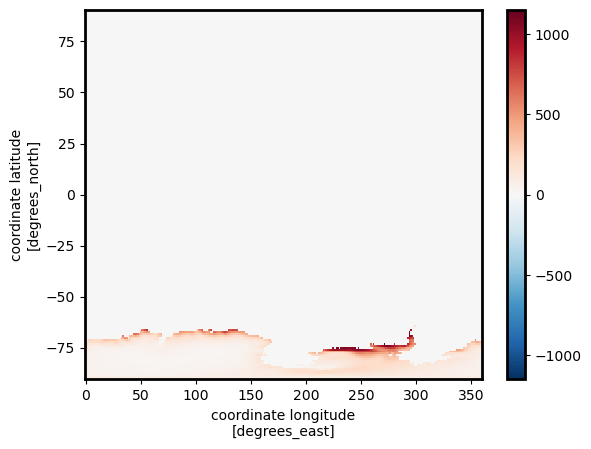

In [25]:
SMB_GOGA_yearly.sel(year=slice("1980", "2013")).mean(dim='year').plot();

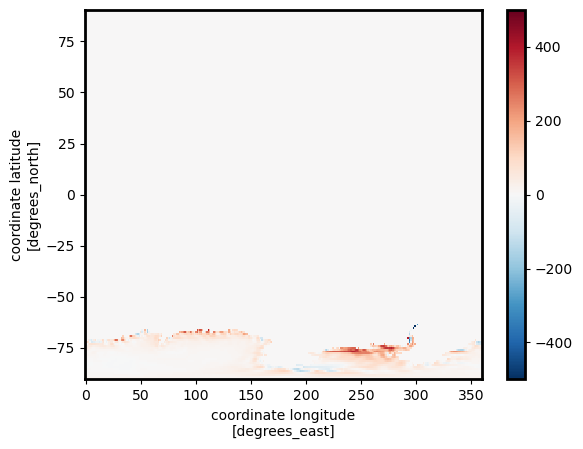

In [26]:
(SMB_GOGA_yearly.sel(year=slice("1980", "2013")).mean(dim='year') - SMB_mw_yearly.mean(dim='year')).plot();

In [8]:
## Grid area
Re = 6371.22 * 1e3  # [m]

f09_mask_file3 = "/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc"
f09_area = xr.open_dataset(f09_mask_file3)["area"]  # [Radian2]
lat = np.array(RAIN_LE.lat)
lon = np.array(RAIN_LE.lon)
f09_area['ni'] = lon
f09_area['nj'] = lat

f09_area_sel = f09_area.sel(nj=slice(-90,-60))

f09_area = f09_area.values * Re**2
f09_area_sel = f09_area_sel.values * Re**2

In [9]:
SMB_MT_int_yearly = (SMB_MT_yearly * f09_area_sel).sum(dim=['lon','lat']) /1e12 #[mm/yr] to [Gt/yr]

SMB_LE_int_yearly = (SMB_LE_yearly * f09_area).sum(dim=['lon','lat']) /1e12 #[Gt/yr]

SMB_TPACE_int_yearly = (SMB_TPACE_yearly * f09_area).sum(dim=['lon','lat']) /1e12 #[Gt/yr]

SMB_GOGA_int_yearly = (SMB_GOGA_yearly * f09_area).sum(dim=['lon','lat']) /1e12 #[Gt/yr]

SMB_TOGA_int_yearly = (SMB_TOGA_yearly * f09_area).sum(dim=['lon','lat']) /1e12 #[Gt/yr]

#SMB_mw_int_yearly = (SMB_mw_yearly * f09_area).sum(dim=['lon','lat']) /1e12 #[Gt/yr]

In [10]:
# Percentage change
dSMB_LE_int_yearly = SMB_LE_int_yearly.sel(year=slice('2005','2019')).mean(dim='year') - SMB_LE_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
dSMB_LE_int_yearly_pct = dSMB_LE_int_yearly / SMB_LE_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
print('CESM2-LEcmip6 (%): ', dSMB_LE_int_yearly_pct.values * 100)

dSMB_TPACE_int_yearly = SMB_TPACE_int_yearly.sel(year=slice('2005','2019')).mean(dim='year') - SMB_TPACE_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
dSMB_TPACE_int_yearly_pct = dSMB_TPACE_int_yearly / SMB_TPACE_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
print('CESM2-TPACE (%): ', dSMB_TPACE_int_yearly_pct.values * 100)

dSMB_GOGA_int_yearly = SMB_GOGA_int_yearly.sel(year=slice('2005','2019')).mean(dim='year') - SMB_GOGA_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
dSMB_GOGA_int_yearly_pct = dSMB_GOGA_int_yearly / SMB_GOGA_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
print('CESM2-GOGA (%): ', dSMB_GOGA_int_yearly_pct.values * 100)

dSMB_TOGA_int_yearly = SMB_TOGA_int_yearly.sel(year=slice('2005','2019')).mean(dim='year') - SMB_TOGA_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
dSMB_TOGA_int_yearly_pct = dSMB_TOGA_int_yearly / SMB_TOGA_int_yearly.sel(year=slice('1979','1993')).mean(dim='year')
print('CESM2-TOGA (%): ', dSMB_TOGA_int_yearly_pct.values * 100)

CESM2-LEcmip6 (%):  4.163127357993552
CESM2-TPACE (%):  4.617617724635062
CESM2-GOGA (%):  -0.13202512486981316
CESM2-TOGA (%):  0.7084729118048493


In [16]:
dSMB_mw_int_yearly = SMB_mw_int_yearly.sel(year=slice('2000','2013')).mean(dim='year') - SMB_mw_int_yearly.sel(year=slice('1980','1993')).mean(dim='year')
dSMB_mw_int_yearly_pct = dSMB_mw_int_yearly / SMB_mw_int_yearly.sel(year=slice('1980','1993')).mean(dim='year')
print('CESM2-meltwater (%): ', dSMB_mw_int_yearly_pct.values * 100)

CESM2-meltwater (%):  0.9498401410952524


In [17]:
## Calculate trend using epoch difference
SMB_LE_trend = (SMB_LE_yearly.sel(year=slice('2000','2014')).mean(dim='year') - SMB_LE_yearly.sel(year=slice('1979','1993')).mean(dim='year')) / 21 #[mm/yr2]
SMB_TPACE_trend = (SMB_TPACE_yearly.sel(year=slice('2000','2014')).mean(dim='year') - SMB_TPACE_yearly.sel(year=slice('1979','1993')).mean(dim='year')) / 21 #[mm/yr2]
SMB_GOGA_trend = (SMB_GOGA_yearly.sel(year=slice('2000','2014')).mean(dim='year') - SMB_GOGA_yearly.sel(year=slice('1979','1993')).mean(dim='year')) / 21 #[mm/yr2]
SMB_TOGA_trend = (SMB_TOGA_yearly.sel(year=slice('2000','2014')).mean(dim='year') - SMB_TOGA_yearly.sel(year=slice('1979','1993')).mean(dim='year')) / 21 #[mm/yr2]
#SMB_mw_trend = (SMB_mw_yearly.sel(year=slice('2000','2013')).mean(dim='year') - SMB_mw_yearly.sel(year=slice('1980','1993')).mean(dim='year')) / 20 #[mm/yr2]

# Set back nan values
SMB_LE_trend = np.where(SMB_LE_trend != 0, SMB_LE_trend, np.NaN)
SMB_TPACE_trend = np.where(SMB_TPACE_trend != 0, SMB_TPACE_trend, np.NaN)
SMB_GOGA_trend = np.where(SMB_GOGA_trend != 0, SMB_GOGA_trend, np.NaN)
SMB_TOGA_trend = np.where(SMB_TOGA_trend != 0, SMB_TOGA_trend, np.NaN)
#SMB_mw_trend = np.where(SMB_mw_trend != 0, SMB_mw_trend, np.NaN)

In [11]:
## Calculate trend using linear regression
#CESM2-LE, 1979-2019
year = np.arange(1979, 2020)
slope_SMB_LE_1979_2019 = SMB_LE_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_LE_yearly.sel(year=slice("1979", "2019"))[:,i,j])
        slope_SMB_LE_1979_2019[i,j] = slope

#CESM2-TPACE, 1979-2019
year = np.arange(1979, 2020)
slope_SMB_TPACE_1979_2019 = SMB_TPACE_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_TPACE_yearly.sel(year=slice("1979", "2019"))[:,i,j])
        slope_SMB_TPACE_1979_2019[i,j] = slope

#CESM2-GOGA, 1979-2019
year = np.arange(1979, 2020)
slope_SMB_GOGA_1979_2019 = SMB_GOGA_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_GOGA_yearly.sel(year=slice("1979", "2019"))[:,i,j])
        slope_SMB_GOGA_1979_2019[i,j] = slope

#CESM2-TOGA, 1979-2019
year = np.arange(1979, 2020)
slope_SMB_TOGA_1979_2019 = SMB_TOGA_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_TOGA_yearly.sel(year=slice("1979", "2019"))[:,i,j])
        slope_SMB_TOGA_1979_2019[i,j] = slope

In [12]:
SMB_LE_trend = slope_SMB_LE_1979_2019
SMB_TPACE_trend = slope_SMB_TPACE_1979_2019
SMB_GOGA_trend = slope_SMB_GOGA_1979_2019
SMB_TOGA_trend = slope_SMB_TOGA_1979_2019

In [13]:
# Set back nan values
SMB_LE_trend = np.where(SMB_LE_trend != 0, SMB_LE_trend, np.NaN)
SMB_TPACE_trend = np.where(SMB_TPACE_trend != 0, SMB_TPACE_trend, np.NaN)
SMB_GOGA_trend = np.where(SMB_GOGA_trend != 0, SMB_GOGA_trend, np.NaN)
SMB_TOGA_trend = np.where(SMB_TOGA_trend != 0, SMB_TOGA_trend, np.NaN)
#SMB_mw_trend = np.where(SMB_mw_trend != 0, SMB_mw_trend, np.NaN)

In [14]:
## Add cyclic points
SMB_LE_trend_full, lon_full = add_cyclic_point(SMB_LE_trend, coord=lon)
SMB_TPACE_trend_full, lon_full = add_cyclic_point(SMB_TPACE_trend, coord=lon)
SMB_GOGA_trend_full, lon_full = add_cyclic_point(SMB_GOGA_trend, coord=lon)
SMB_TOGA_trend_full, lon_full = add_cyclic_point(SMB_TOGA_trend, coord=lon)
#SMB_mw_trend_full, lon_full = add_cyclic_point(SMB_mw_trend, coord=lon)

#### Spatial correlation

In [15]:
# CESM2-GOGA
SMB_GOGA_trend_flat = SMB_GOGA_trend.flatten()
SMB_GOGA_trend_flat_nonan = SMB_GOGA_trend_flat[~np.isnan(SMB_GOGA_trend_flat)]

In [16]:
# Correlation
SMB_LE_trend_flat = SMB_LE_trend.flatten()
SMB_LE_trend_flat_nonan = SMB_LE_trend_flat[~np.isnan(SMB_LE_trend_flat)]
SMB_LE_trend_cor, _ = pearsonr(SMB_GOGA_trend_flat_nonan, SMB_LE_trend_flat_nonan)
print('CESM2-LE: ', SMB_LE_trend_cor)

SMB_TPACE_trend_flat = SMB_TPACE_trend.flatten()
SMB_TPACE_trend_flat_nonan = SMB_TPACE_trend_flat[~np.isnan(SMB_TPACE_trend_flat)]
SMB_TPACE_trend_cor, _ = pearsonr(SMB_GOGA_trend_flat_nonan, SMB_TPACE_trend_flat_nonan)
print('CESM2-TPACE: ', SMB_TPACE_trend_cor)

SMB_TOGA_trend_flat = SMB_TOGA_trend.flatten()
SMB_TOGA_trend_flat_nonan = SMB_TOGA_trend_flat[~np.isnan(SMB_TOGA_trend_flat)]
SMB_TOGA_trend_cor, _ = pearsonr(SMB_GOGA_trend_flat_nonan, SMB_TOGA_trend_flat_nonan)
print('CESM2-TOGA: ', SMB_TOGA_trend_cor)

#SMB_mw_trend_flat = SMB_mw_trend.flatten()
#SMB_mw_trend_flat_nonan = SMB_mw_trend_flat[~np.isnan(SMB_mw_trend_flat)]
#SMB_mw_trend_cor, _ = pearsonr(SMB_GOGA_trend_flat_nonan, SMB_mw_trend_flat_nonan)
#print('CESM1-mv: ', SMB_mw_trend_cor)

CESM2-LE:  0.16267382837690342
CESM2-TPACE:  0.5578472496361224
CESM2-TOGA:  0.8956476123539947


## Plot

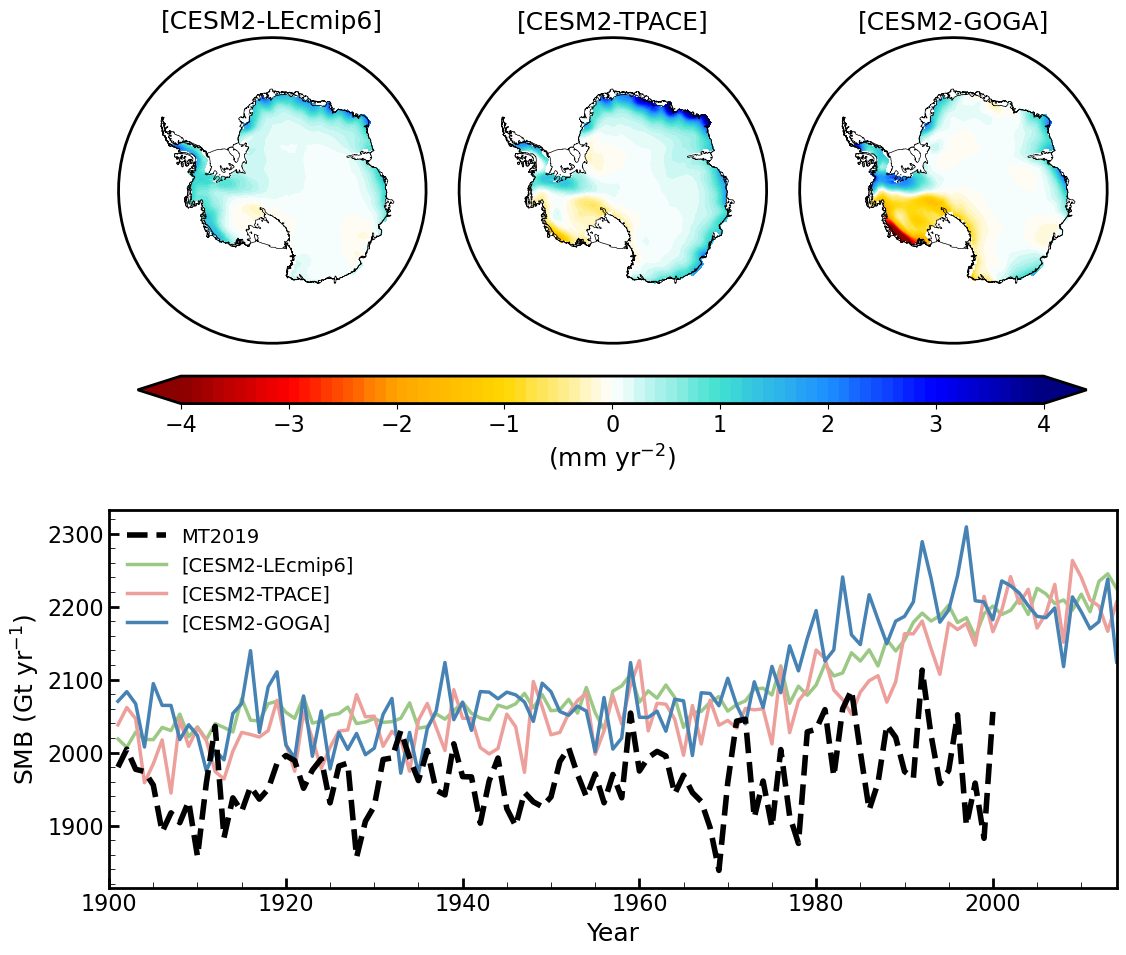

In [45]:
#fig = plt.figure(figsize=(13, 5))
#gs = GridSpec(5, 12)
fig = plt.figure(figsize=(13, 11))
gs = GridSpec(11, 12)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_title = 18
size_tick = 16
size_label = 18
size_legend = 14
width_line = 2.5
width_box = 1.9

level_SMB = np.arange(-4, 4.01, 0.1)
ticks_SMB = np.arange(-4, 4.01, 1.)

cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0:4,0:4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1 = ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax1.set_title('[CESM2-LEcmip6]', pad=9, fontsize=size_title)#, fontweight='bold')

######################### Subplot2 #########################
ax2 = plt.subplot(gs[0:4,4:8], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2 = ax2.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax2.set_title('[CESM2-TPACE]', pad=9, fontsize=size_title)#, fontweight='bold')

######################### Subplot3 #########################
ax3 = plt.subplot(gs[0:4,8:12], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3 = ax3.contourf(lon_full, lat, SMB_GOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax3.set_title('[CESM2-GOGA]', pad=9, fontsize=size_title)#, fontweight='bold')

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.55, 0.73, 0.025]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im3, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('(mm yr$^{-2}$)', size=size_label)

######################### Subplot4 #########################
ax4 = plt.subplot(gs[6:11,:])

#plt.axvline(x=2000, linestyle="--", color="lightgray", linewidth=1)
ax4.plot(SMB_MT_int_yearly.year, SMB_MT_int_yearly, color="black", linestyle="--", linewidth=width_line+1.5, label="MT2019", zorder=5)
ax4.plot(SMB_LE_int_yearly.year, SMB_LE_int_yearly, color="#9BC985", linewidth=width_line, label="[CESM2-LEcmip6]")
ax4.plot(SMB_TPACE_int_yearly.year, SMB_TPACE_int_yearly, color="#ED9F9B", linewidth=width_line, label="[CESM2-TPACE]")
ax4.plot(SMB_GOGA_int_yearly.year, SMB_GOGA_int_yearly, color="steelblue", linewidth=width_line, label="[CESM2-GOGA]")

ax4.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax4.set_xlim([1900, 2014])
#ax4.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
ax4.set_xlabel("Year", fontsize=size_label)
ax4.set_ylabel("SMB (Gt yr$^{-1}$)", fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="major", length=7, width=2, direction="in")
ax4.tick_params(which="minor", length=4, direction="in")
# ax4.set_yticks([-1000, -500, 0, 500])
ax4.tick_params(labelsize=size_tick)

plt.savefig(
    "Figure_S9_v1.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

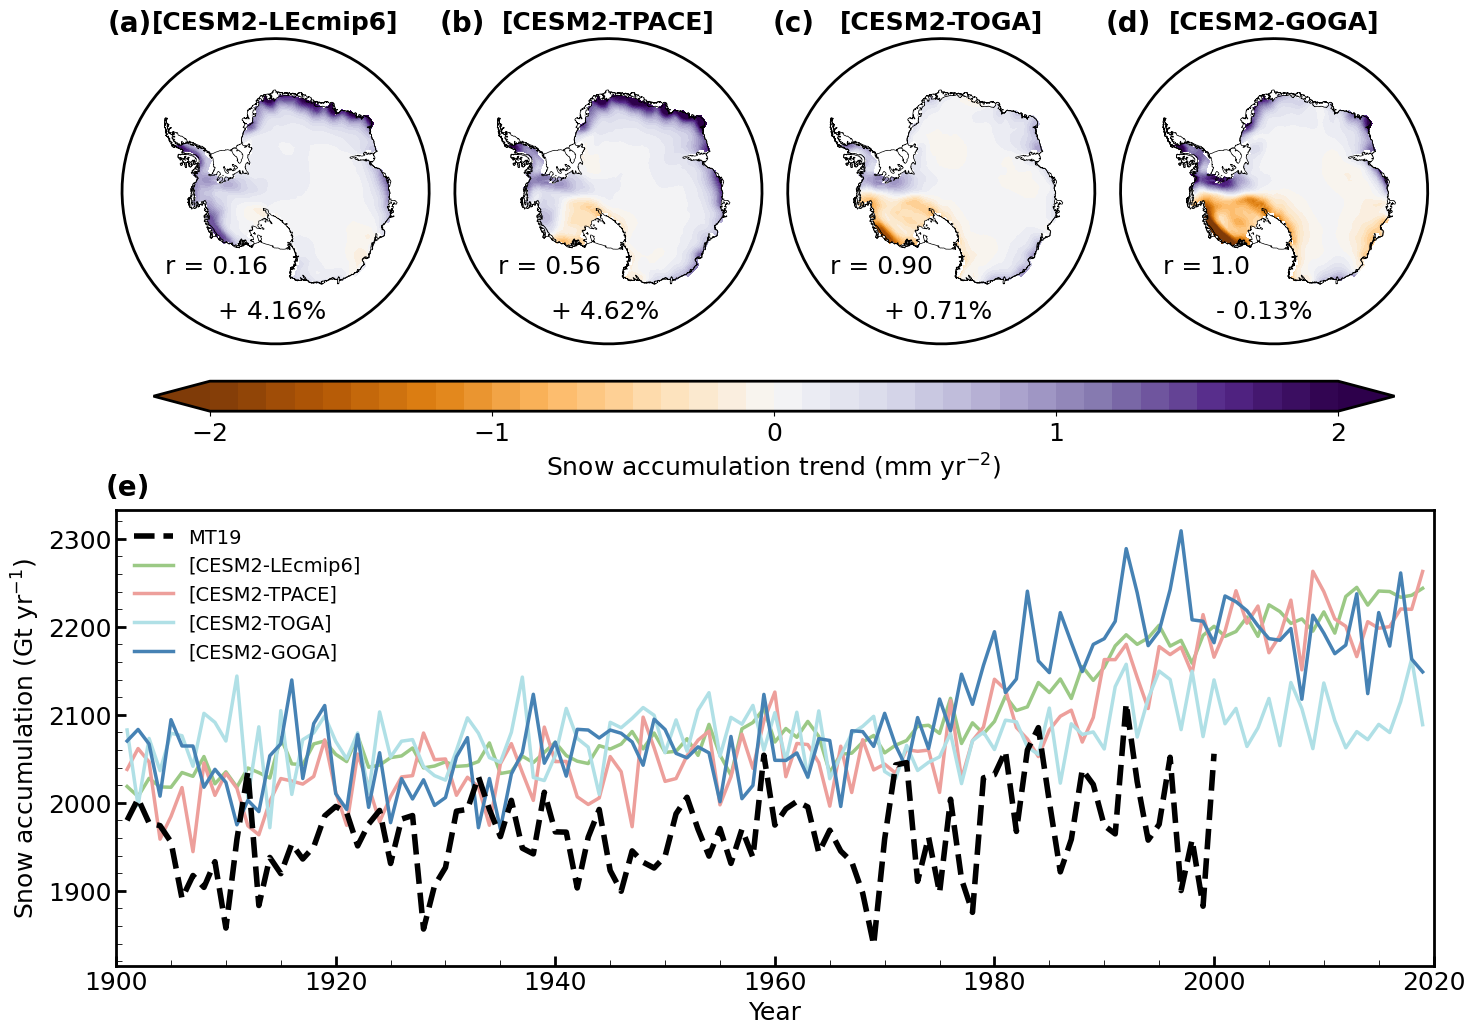

In [21]:
# Remove CESM1-meltwater hosting, add CESM2-TOGA
fig = plt.figure(figsize=(17, 12))
gs = GridSpec(12, 16)
plt.rcParams["axes.linewidth"] = 2  # set the value globally
plt.rcParams['axes.titlepad'] =14

size_title = 18
size_tick = 18
size_label = 18
size_legend = 14
size_text = 18
width_line = 2.5

level_SMB = np.arange(-2, 2.01, 0.1)
ticks_SMB = np.arange(-2, 2.01, 1.)

cmap1 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0:4,0:4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1 = ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax1.text(-3800000, 3570000, '(a)', fontsize=size_title+2, fontweight='bold')
ax1.set_title('[CESM2-LEcmip6]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.16', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.16%', fontsize=size_text)

######################### Subplot2 #########################
ax2 = plt.subplot(gs[0:4,4:8], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2 = ax2.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax2.text(-3800000, 3570000, '(b)', fontsize=size_title+2, fontweight='bold')
ax2.set_title('[CESM2-TPACE]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.56', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.62%', fontsize=size_text)

######################### Subplot3 #########################
ax3 = plt.subplot(gs[0:4,8:12], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3 = ax3.contourf(lon_full, lat, SMB_TOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax3.text(-3800000, 3570000, '(c)', fontsize=size_title+2, fontweight='bold')
ax3.set_title('[CESM2-TOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.90', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 0.71%', fontsize=size_text)

######################### Subplot4 #########################
ax4 = plt.subplot(gs[0:4,12:16], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4 = ax4.contourf(lon_full, lat, SMB_GOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax4.text(-3800000, 3570000, '(d)', fontsize=size_title+2, fontweight='bold')
ax4.set_title('[CESM2-GOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 1.0', fontsize=size_text)
plt.text(-1300000, -2900000, '- 0.13%', fontsize=size_text)

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.572, 0.73, 0.025]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im4, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)

######################### Subplot5 #########################
ax4 = plt.subplot(gs[6:12,:])

#plt.axvline(x=2000, linestyle="--", color="lightgray", linewidth=1)
ax4.plot(SMB_MT_int_yearly.year, SMB_MT_int_yearly, color="black", linestyle="--", linewidth=width_line+1.5, label="MT19", zorder=5)
ax4.plot(SMB_LE_int_yearly.year, SMB_LE_int_yearly, color="#9BC985", linewidth=width_line, label="[CESM2-LEcmip6]")
ax4.plot(SMB_TPACE_int_yearly.year, SMB_TPACE_int_yearly, color="#ED9F9B", linewidth=width_line, label="[CESM2-TPACE]")
ax4.plot(SMB_TOGA_int_yearly.year, SMB_TOGA_int_yearly, color="powderblue", linewidth=width_line, label="[CESM2-TOGA]")
ax4.plot(SMB_GOGA_int_yearly.year, SMB_GOGA_int_yearly, color="steelblue", linewidth=width_line, label="[CESM2-GOGA]")
#ax4.plot(SMB_mw_int_yearly.year, SMB_mw_int_yearly, color="#C6B3D3", linewidth=width_line, label="[CESM1-meltwater]")

ax4.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax4.set_xlim([1900, 2020])
#ax4.set_ylim([1520, 2340])
ax4.set_xlabel("Year", fontsize=size_label)
ax4.set_ylabel("Snow accumulation (Gt yr$^{-1}$)", fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="major", length=7, width=2, direction="in")
ax4.tick_params(which="minor", length=4, direction="in")
# ax4.set_yticks([-1000, -500, 0, 500])
ax4.tick_params(labelsize=size_tick)
ax4.text(1899, 2350, '(e)', fontsize=size_title+2, fontweight='bold')

plt.savefig(
    "plot/F6_map_AIS_SMB_trend_tseries_SMB.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

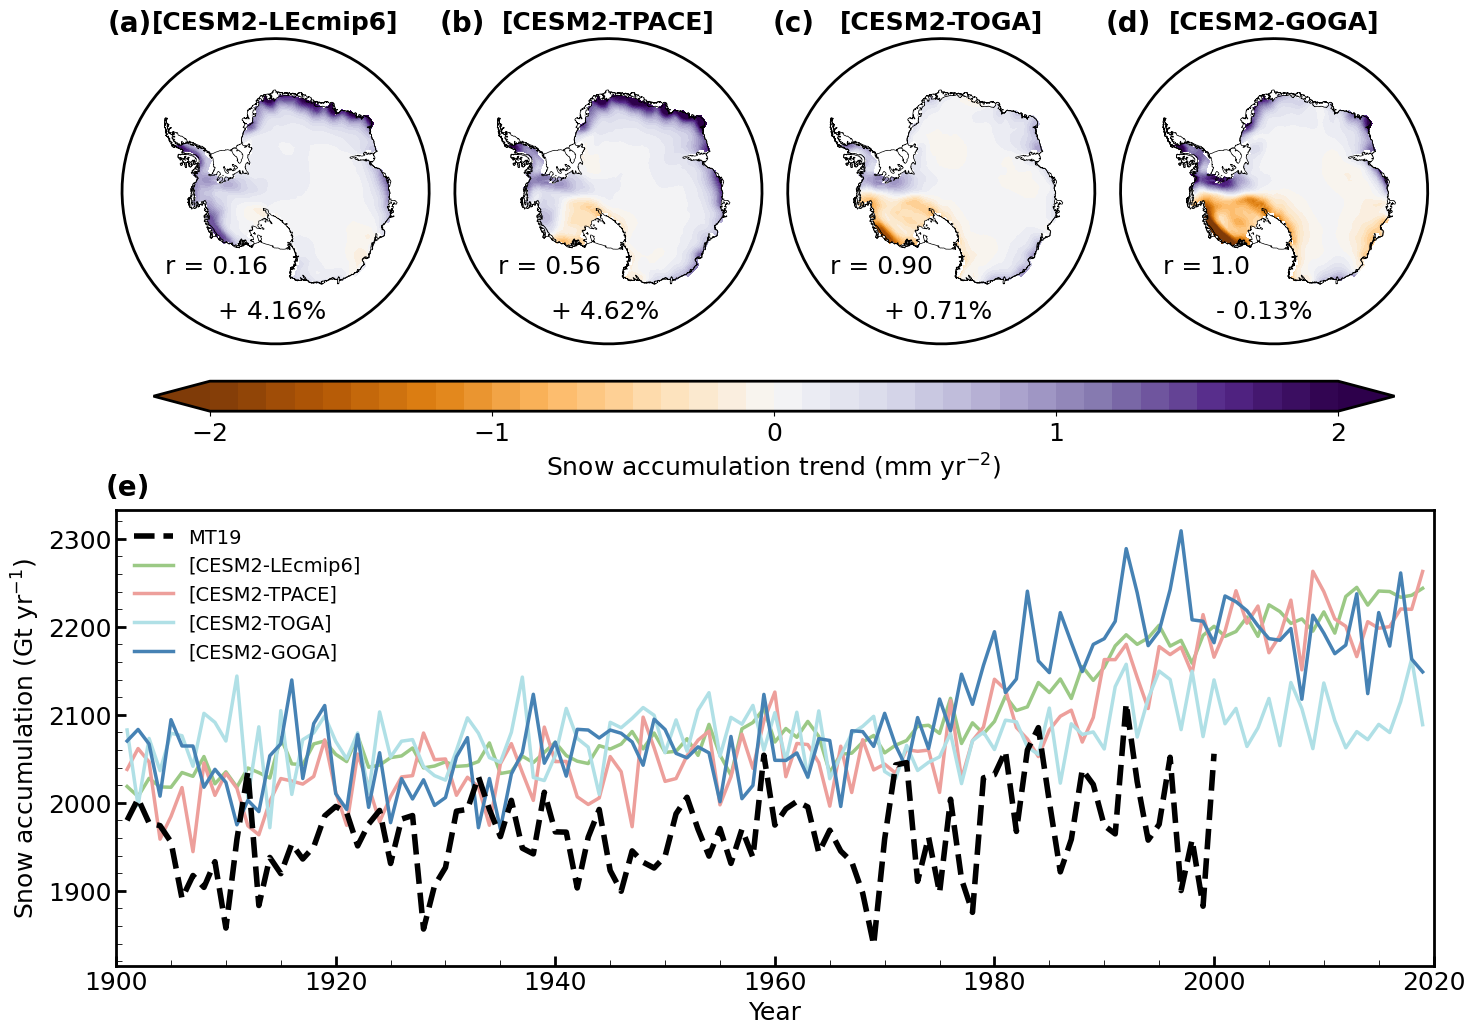

In [22]:
# Save in pdf format
fig = plt.figure(figsize=(17, 12))
gs = GridSpec(12, 16)
plt.rcParams["axes.linewidth"] = 2  # set the value globally
plt.rcParams['axes.titlepad'] =14

size_title = 18
size_tick = 18
size_label = 18
size_legend = 14
size_text = 18
width_line = 2.5

level_SMB = np.arange(-2, 2.01, 0.1)
ticks_SMB = np.arange(-2, 2.01, 1.)

cmap1 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0:4,0:4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1 = ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax1.text(-3800000, 3570000, '(a)', fontsize=size_title+2, fontweight='bold')
ax1.set_title('[CESM2-LEcmip6]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.16', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.16%', fontsize=size_text)

######################### Subplot2 #########################
ax2 = plt.subplot(gs[0:4,4:8], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2 = ax2.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax2.text(-3800000, 3570000, '(b)', fontsize=size_title+2, fontweight='bold')
ax2.set_title('[CESM2-TPACE]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.56', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.62%', fontsize=size_text)

######################### Subplot3 #########################
ax3 = plt.subplot(gs[0:4,8:12], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3 = ax3.contourf(lon_full, lat, SMB_TOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax3.text(-3800000, 3570000, '(c)', fontsize=size_title+2, fontweight='bold')
ax3.set_title('[CESM2-TOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.90', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 0.71%', fontsize=size_text)

######################### Subplot4 #########################
ax4 = plt.subplot(gs[0:4,12:16], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4 = ax4.contourf(lon_full, lat, SMB_GOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax4.text(-3800000, 3570000, '(d)', fontsize=size_title+2, fontweight='bold')
ax4.set_title('[CESM2-GOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 1.0', fontsize=size_text)
plt.text(-1300000, -2900000, '- 0.13%', fontsize=size_text)

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.572, 0.73, 0.025]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im4, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)

######################### Subplot5 #########################
ax4 = plt.subplot(gs[6:12,:])

#plt.axvline(x=2000, linestyle="--", color="lightgray", linewidth=1)
ax4.plot(SMB_MT_int_yearly.year, SMB_MT_int_yearly, color="black", linestyle="--", linewidth=width_line+1.5, label="MT19", zorder=5)
ax4.plot(SMB_LE_int_yearly.year, SMB_LE_int_yearly, color="#9BC985", linewidth=width_line, label="[CESM2-LEcmip6]")
ax4.plot(SMB_TPACE_int_yearly.year, SMB_TPACE_int_yearly, color="#ED9F9B", linewidth=width_line, label="[CESM2-TPACE]")
ax4.plot(SMB_TOGA_int_yearly.year, SMB_TOGA_int_yearly, color="powderblue", linewidth=width_line, label="[CESM2-TOGA]")
ax4.plot(SMB_GOGA_int_yearly.year, SMB_GOGA_int_yearly, color="steelblue", linewidth=width_line, label="[CESM2-GOGA]")
#ax4.plot(SMB_mw_int_yearly.year, SMB_mw_int_yearly, color="#C6B3D3", linewidth=width_line, label="[CESM1-meltwater]")

ax4.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax4.set_xlim([1900, 2020])
#ax4.set_ylim([1520, 2340])
ax4.set_xlabel("Year", fontsize=size_label)
ax4.set_ylabel("Snow accumulation (Gt yr$^{-1}$)", fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="major", length=7, width=2, direction="in")
ax4.tick_params(which="minor", length=4, direction="in")
# ax4.set_yticks([-1000, -500, 0, 500])
ax4.tick_params(labelsize=size_tick)
ax4.text(1899, 2350, '(e)', fontsize=size_title+2, fontweight='bold')


plt.savefig(
    'plot/F6_map_AIS_SMB_trend_tseries_SMB.pdf',
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

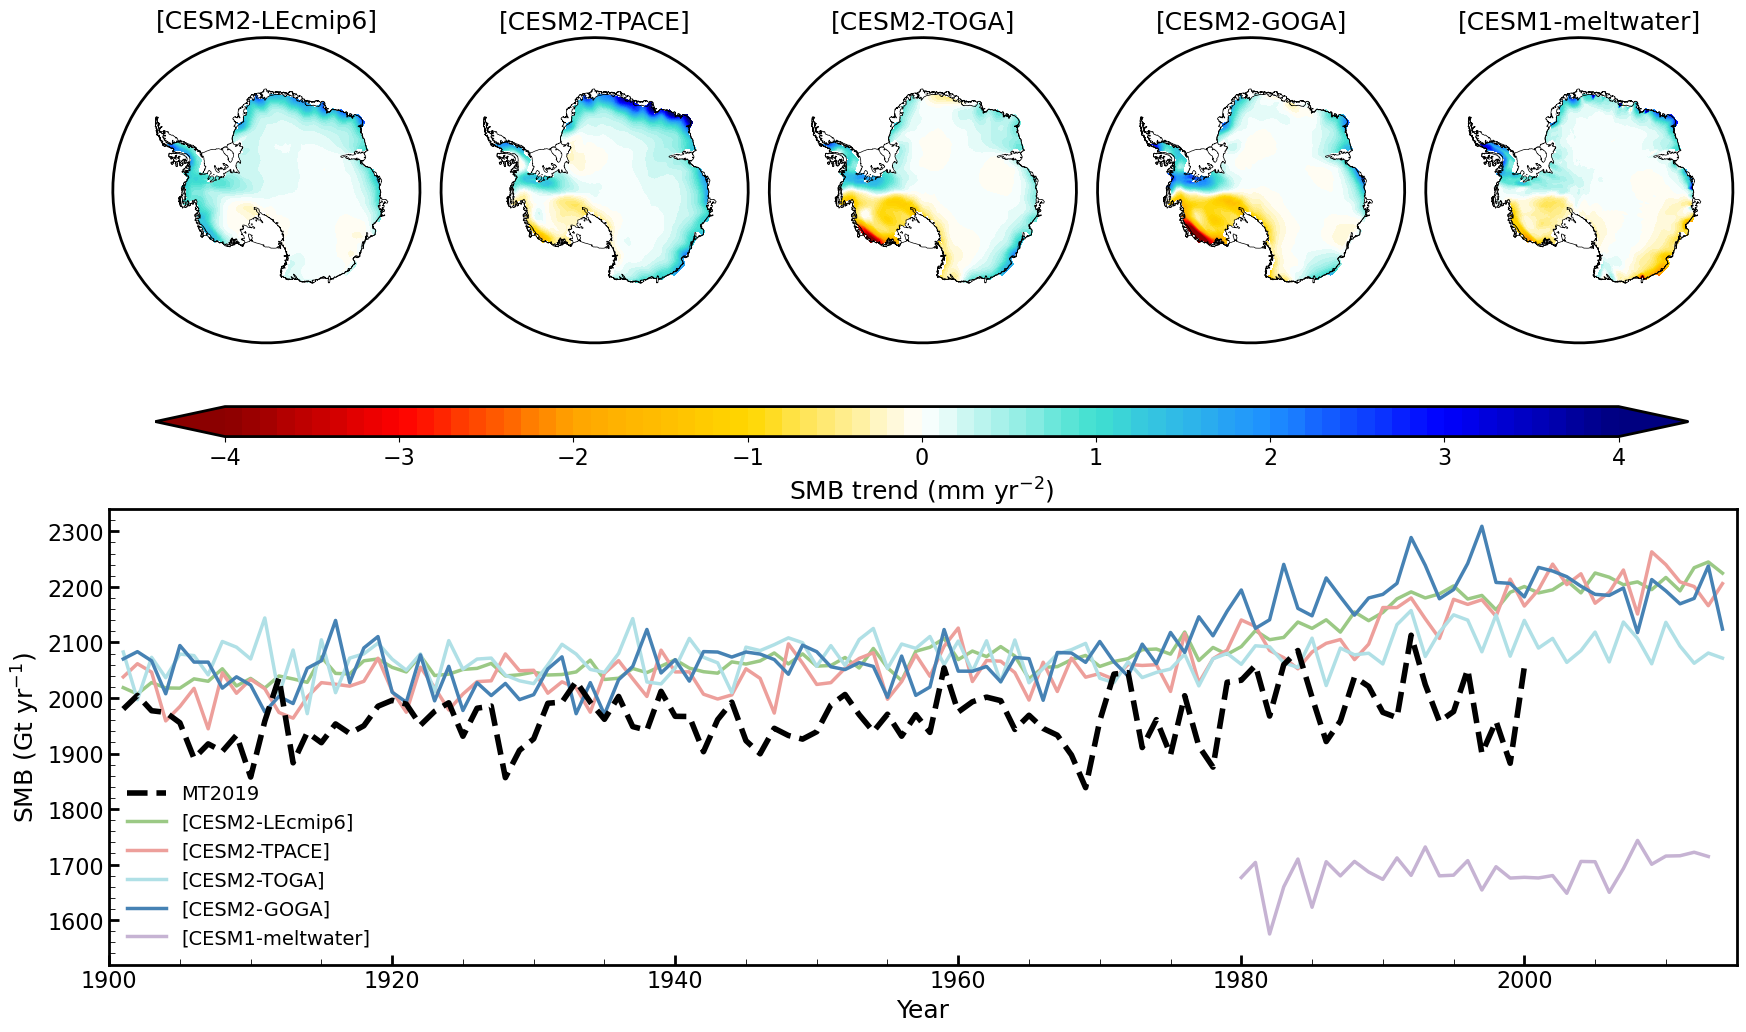

In [28]:
# 1x5, Add CESM2-TOGA
fig = plt.figure(figsize=(21, 12))
gs = GridSpec(12, 20)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_title = 18
size_tick = 16
size_label = 18
size_legend = 14
width_line = 2.5
width_box = 1.9

level_SMB = np.arange(-4, 4.01, 0.1)
ticks_SMB = np.arange(-4, 4.01, 1.)

cmap1 = colors.LinearSegmentedColormap.from_list("", ["darkred", "red", "orange", "gold", "white", "turquoise", "dodgerblue", "blue", "navy"])

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0:4,0:4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1 = ax1.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax1.set_title('[CESM2-LEcmip6]', pad=9, fontsize=size_title)#, fontweight='bold')

######################### Subplot2 #########################
ax2 = plt.subplot(gs[0:4,4:8], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2 = ax2.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax2.set_title('[CESM2-TPACE]', pad=9, fontsize=size_title)#, fontweight='bold')

######################### Subplot3 #########################
ax3 = plt.subplot(gs[0:4,8:12], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3 = ax3.contourf(lon_full, lat, SMB_TOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax3.set_title('[CESM2-TOGA]', pad=9, fontsize=size_title)#, fontweight='bold')

######################### Subplot4 #########################
ax4 = plt.subplot(gs[0:4,12:16], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4 = ax4.contourf(lon_full, lat, SMB_GOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax4.set_title('[CESM2-GOGA]', pad=9, fontsize=size_title)#, fontweight='bold')

######################### Subplot5 #########################
ax5 = plt.subplot(gs[0:4,16:20], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax5, -60)

im5 = ax5.contourf(lon_full, lat, SMB_mw_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax5.set_title('[CESM1-meltwater]', pad=9, fontsize=size_title)#, fontweight='bold')

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.55, 0.73, 0.025]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im5, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('SMB trend (mm yr$^{-2}$)', size=size_label)

######################### Subplot5 #########################
ax6 = plt.subplot(gs[6:12,:])

#plt.axvline(x=2000, linestyle="--", color="lightgray", linewidth=1)
ax6.plot(SMB_MT_int_yearly.year, SMB_MT_int_yearly, color="black", linestyle="--", linewidth=width_line+1.5, label="MT2019", zorder=5)
ax6.plot(SMB_LE_int_yearly.year, SMB_LE_int_yearly, color="#9BC985", linewidth=width_line, label="[CESM2-LEcmip6]")
ax6.plot(SMB_TPACE_int_yearly.year, SMB_TPACE_int_yearly, color="#ED9F9B", linewidth=width_line, label="[CESM2-TPACE]")
ax6.plot(SMB_TOGA_int_yearly.year, SMB_TOGA_int_yearly, color="powderblue", linewidth=width_line, label="[CESM2-TOGA]")
ax6.plot(SMB_GOGA_int_yearly.year, SMB_GOGA_int_yearly, color="steelblue", linewidth=width_line, label="[CESM2-GOGA]")
ax6.plot(SMB_mw_int_yearly.year, SMB_mw_int_yearly, color="#C6B3D3", linewidth=width_line, label="[CESM1-meltwater]")

ax6.legend(loc="lower left", frameon=False, prop={"size": size_legend}, ncol=1)

ax6.set_xlim([1900, 2015])
ax6.set_ylim([1520, 2340])
ax6.set_xlabel("Year", fontsize=size_label)
ax6.set_ylabel("SMB (Gt yr$^{-1}$)", fontsize=size_label)
ax6.xaxis.set_minor_locator(AutoMinorLocator())
ax6.yaxis.set_minor_locator(AutoMinorLocator())
ax6.tick_params(which="major", length=7, width=2, direction="in")
ax6.tick_params(which="minor", length=4, direction="in")
# ax6.set_yticks([-1000, -500, 0, 500])
ax6.tick_params(labelsize=size_tick)

plt.savefig(
    "plot/Figure_S9_v4.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

#### Change order to: GOGA, TOGA, CESM2-LEcmip6, CESM2-TPACE

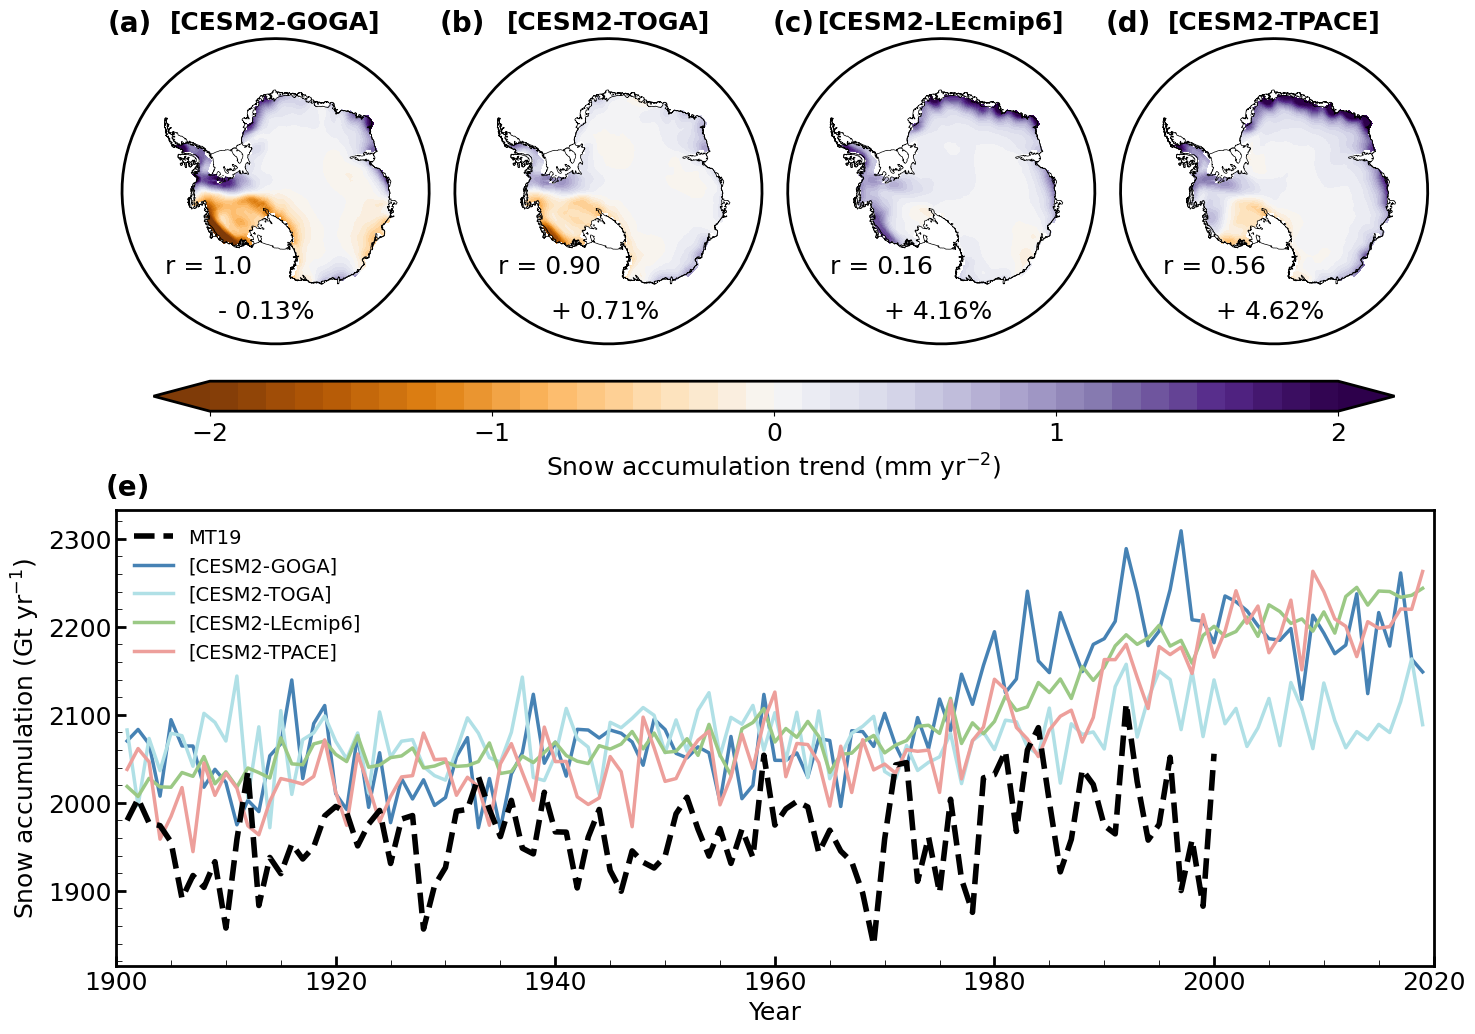

In [18]:
# 
fig = plt.figure(figsize=(17, 12))
gs = GridSpec(12, 16)
plt.rcParams["axes.linewidth"] = 2  # set the value globally
plt.rcParams['axes.titlepad'] =14

size_title = 18
size_tick = 18
size_label = 18
size_legend = 14
size_text = 18
width_line = 2.5

level_SMB = np.arange(-2, 2.01, 0.1)
ticks_SMB = np.arange(-2, 2.01, 1.)

cmap1 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0:4,0:4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1 = ax1.contourf(lon_full, lat, SMB_GOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax1.text(-3800000, 3570000, '(a)', fontsize=size_title+2, fontweight='bold')
ax1.set_title('[CESM2-GOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 1.0', fontsize=size_text)
plt.text(-1300000, -2900000, '- 0.13%', fontsize=size_text)

######################### Subplot2 #########################
ax2 = plt.subplot(gs[0:4,4:8], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2 = ax2.contourf(lon_full, lat, SMB_TOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax2.text(-3800000, 3570000, '(b)', fontsize=size_title+2, fontweight='bold')
ax2.set_title('[CESM2-TOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.90', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 0.71%', fontsize=size_text)

######################### Subplot3 #########################
ax3 = plt.subplot(gs[0:4,8:12], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3 = ax3.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax3.text(-3800000, 3570000, '(c)', fontsize=size_title+2, fontweight='bold')
ax3.set_title('[CESM2-LEcmip6]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.16', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.16%', fontsize=size_text)

######################### Subplot4 #########################
ax4 = plt.subplot(gs[0:4,12:16], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4 = ax4.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax4.text(-3800000, 3570000, '(d)', fontsize=size_title+2, fontweight='bold')
ax4.set_title('[CESM2-TPACE]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.56', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.62%', fontsize=size_text)

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.572, 0.73, 0.025]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im4, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)

######################### Subplot5 #########################
ax4 = plt.subplot(gs[6:12,:])

#plt.axvline(x=2000, linestyle="--", color="lightgray", linewidth=1)
ax4.plot(SMB_MT_int_yearly.year, SMB_MT_int_yearly, color="black", linestyle="--", linewidth=width_line+1.5, label="MT19", zorder=5)
ax4.plot(SMB_GOGA_int_yearly.year, SMB_GOGA_int_yearly, color="steelblue", linewidth=width_line, label="[CESM2-GOGA]")
ax4.plot(SMB_TOGA_int_yearly.year, SMB_TOGA_int_yearly, color="powderblue", linewidth=width_line, label="[CESM2-TOGA]")
ax4.plot(SMB_LE_int_yearly.year, SMB_LE_int_yearly, color="#9BC985", linewidth=width_line, label="[CESM2-LEcmip6]")
ax4.plot(SMB_TPACE_int_yearly.year, SMB_TPACE_int_yearly, color="#ED9F9B", linewidth=width_line, label="[CESM2-TPACE]")
#ax4.plot(SMB_mw_int_yearly.year, SMB_mw_int_yearly, color="#C6B3D3", linewidth=width_line, label="[CESM1-meltwater]")
ax4.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax4.set_xlim([1900, 2020])
#ax4.set_ylim([1520, 2340])
ax4.set_xlabel("Year", fontsize=size_label)
ax4.set_ylabel("Snow accumulation (Gt yr$^{-1}$)", fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="major", length=7, width=2, direction="in")
ax4.tick_params(which="minor", length=4, direction="in")
# ax4.set_yticks([-1000, -500, 0, 500])
ax4.tick_params(labelsize=size_tick)
ax4.text(1899, 2350, '(e)', fontsize=size_title+2, fontweight='bold')

plt.savefig(
    "plot/F6_map_AIS_SMB_trend_tseries_SMB_250719.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

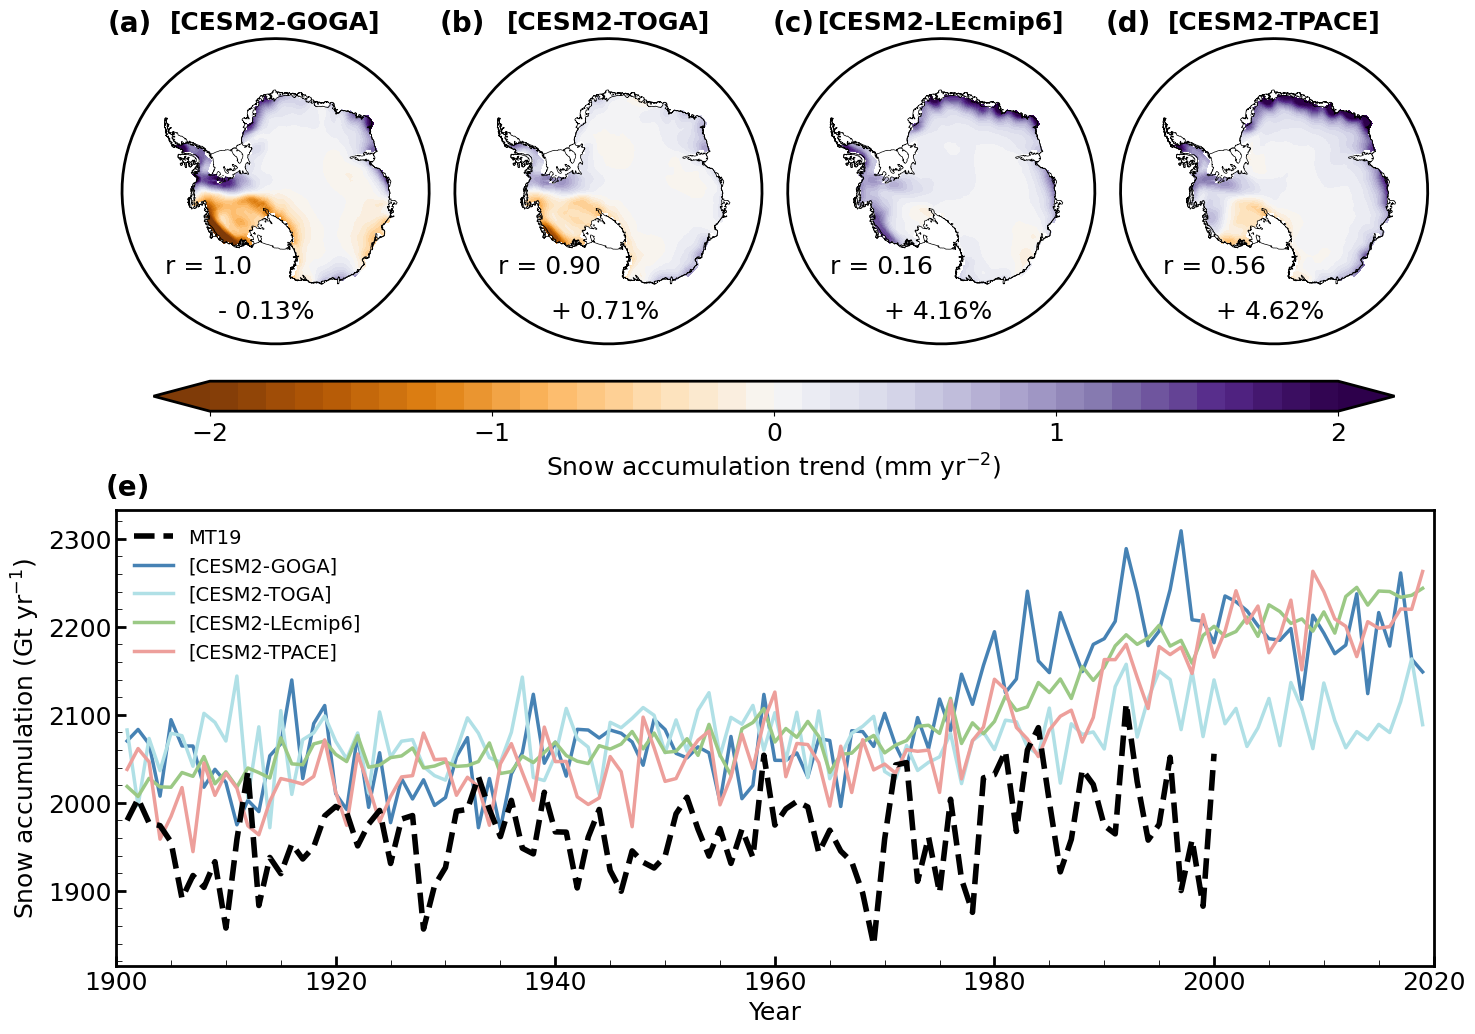

In [19]:
# Save in pdf format
fig = plt.figure(figsize=(17, 12))
gs = GridSpec(12, 16)
plt.rcParams["axes.linewidth"] = 2  # set the value globally
plt.rcParams['axes.titlepad'] =14

size_title = 18
size_tick = 18
size_label = 18
size_legend = 14
size_text = 18
width_line = 2.5

level_SMB = np.arange(-2, 2.01, 0.1)
ticks_SMB = np.arange(-2, 2.01, 1.)

cmap1 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0:4,0:4], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -60)

im1 = ax1.contourf(lon_full, lat, SMB_GOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax1.text(-3800000, 3570000, '(a)', fontsize=size_title+2, fontweight='bold')
ax1.set_title('[CESM2-GOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 1.0', fontsize=size_text)
plt.text(-1300000, -2900000, '- 0.13%', fontsize=size_text)

######################### Subplot2 #########################
ax2 = plt.subplot(gs[0:4,4:8], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -60)

im2 = ax2.contourf(lon_full, lat, SMB_TOGA_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax2.text(-3800000, 3570000, '(b)', fontsize=size_title+2, fontweight='bold')
ax2.set_title('[CESM2-TOGA]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.90', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 0.71%', fontsize=size_text)

######################### Subplot3 #########################
ax3 = plt.subplot(gs[0:4,8:12], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -60)

im3 = ax3.contourf(lon_full, lat, SMB_LE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax3.text(-3800000, 3570000, '(c)', fontsize=size_title+2, fontweight='bold')
ax3.set_title('[CESM2-LEcmip6]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.16', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.16%', fontsize=size_text)

######################### Subplot4 #########################
ax4 = plt.subplot(gs[0:4,12:16], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -60)

im4 = ax4.contourf(lon_full, lat, SMB_TPACE_trend_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both')

ax4.text(-3800000, 3570000, '(d)', fontsize=size_title+2, fontweight='bold')
ax4.set_title('[CESM2-TPACE]', pad=9, fontsize=size_title, fontweight='bold')
plt.text(-2500000, -1900000, 'r = 0.56', fontsize=size_text)
plt.text(-1300000, -2900000, '+ 4.62%', fontsize=size_text)

#Colorbar
cbar_ax = fig.add_axes([0.147, 0.572, 0.73, 0.025]) #[from left, from bottom, width, height]
cbar = fig.colorbar(im4, cax=cbar_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar.ax.tick_params(labelsize=size_tick)
cbar.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)

######################### Subplot5 #########################
ax4 = plt.subplot(gs[6:12,:])

#plt.axvline(x=2000, linestyle="--", color="lightgray", linewidth=1)
ax4.plot(SMB_MT_int_yearly.year, SMB_MT_int_yearly, color="black", linestyle="--", linewidth=width_line+1.5, label="MT19", zorder=5)
ax4.plot(SMB_GOGA_int_yearly.year, SMB_GOGA_int_yearly, color="steelblue", linewidth=width_line, label="[CESM2-GOGA]")
ax4.plot(SMB_TOGA_int_yearly.year, SMB_TOGA_int_yearly, color="powderblue", linewidth=width_line, label="[CESM2-TOGA]")
ax4.plot(SMB_LE_int_yearly.year, SMB_LE_int_yearly, color="#9BC985", linewidth=width_line, label="[CESM2-LEcmip6]")
ax4.plot(SMB_TPACE_int_yearly.year, SMB_TPACE_int_yearly, color="#ED9F9B", linewidth=width_line, label="[CESM2-TPACE]")
#ax4.plot(SMB_mw_int_yearly.year, SMB_mw_int_yearly, color="#C6B3D3", linewidth=width_line, label="[CESM1-meltwater]")
ax4.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax4.set_xlim([1900, 2020])
#ax4.set_ylim([1520, 2340])
ax4.set_xlabel("Year", fontsize=size_label)
ax4.set_ylabel("Snow accumulation (Gt yr$^{-1}$)", fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which="major", length=7, width=2, direction="in")
ax4.tick_params(which="minor", length=4, direction="in")
# ax4.set_yticks([-1000, -500, 0, 500])
ax4.tick_params(labelsize=size_tick)
ax4.text(1899, 2350, '(e)', fontsize=size_title+2, fontweight='bold')


plt.savefig(
    'plot/F6_map_AIS_SMB_trend_tseries_SMB_2507.pdf',
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)